In [1]:
import numpy as np
import scipy as scp
from numpy.random import multivariate_normal
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score as nmi
N_SAMPLES = 200

In [2]:
#Create simulated data
def get_synth_data():
    c1_means = [1, 1]
    c2_means = [3, 4]
    c1_cov = [[1, 0.5],[0.5, 1.5]]
    c2_cov = [[0.3, 0.2],[0.2, 0.6]]
    means = [c1_means, c2_means]
    cov = [c1_cov, c2_cov]
    
    v_data = list()
    for co in range(2):
        samples = multivariate_normal(means[co], cov[co], N_SAMPLES)
        v_data.append(samples)
            
    v_data = np.vstack(v_data)
    
    labels = np.concatenate((np.zeros((N_SAMPLES,)), np.ones((N_SAMPLES,))))
    
    shuffle_inds = np.random.permutation(N_SAMPLES * 2)
    v_data = v_data[shuffle_inds]
    labels = labels[shuffle_inds]
    
    return v_data, labels

(400, 2)


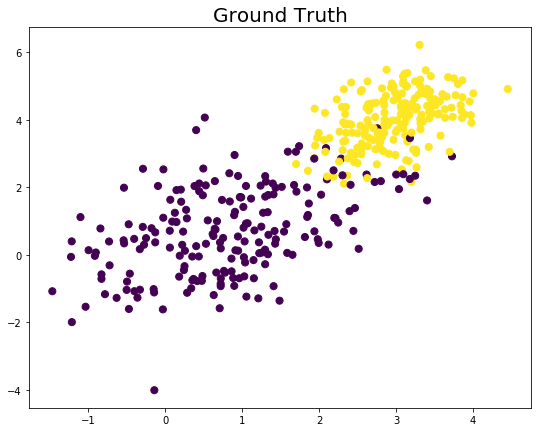

In [3]:
#Show ground truth for data
data, labels  = get_synth_data()
cmap = 'viridis'
dot_size=50
fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Ground Truth', size=20)
ax.scatter(data[:, 0], data[:, 1],c=labels,s=dot_size, cmap=cmap)
print(data.shape)

(400, 2)


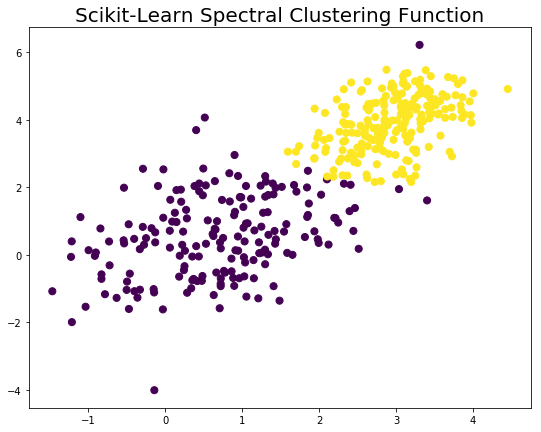

In [4]:
clustering = SpectralClustering(n_clusters=2)
predictions = clustering.fit_predict(data)
fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Scikit-Learn Spectral Clustering Function', size=20)
ax.scatter(data[:, 0], data[:, 1],c=predictions,s=dot_size, cmap=cmap)
print(data.shape)

In [5]:
def gaussian_sim(X_mat):
    
    samples = X_mat.shape[0]
    distances = list()
    for ind1 in range(samples):
        distances.append(np.linalg.norm(X_mat - X_mat[ind1].reshape(1, -1), axis = 1))
    distances = np.vstack(distances)
    sq_dists = np.square(distances)
    norm_dists = sq_dists
    sims = np.exp(-norm_dists)
    
    return sims

def comp_laplacian2(X_mat, k):
    D_mat = np.zeros((X_mat.shape[0], X_mat.shape[1]))
    for ind in range(X_mat.shape[0]):
        D_mat[ind, ind] = np.power(np.sum(X_mat[ind]), -0.5)
    laplacian = np.matmul(D_mat, X_mat)
    laplacian = np.matmul(laplacian, D_mat)
    print(laplacian)
    return laplacian

def comp_laplacian(X_mat, k):
    D_mat = np.zeros((X_mat.shape[0], X_mat.shape[1]))
    for ind in range(X_mat.shape[0]):
        D_mat[ind, ind] = np.sum(X_mat[ind])
    #laplacian = np.matmul(D_mat, X_mat)
    #laplacian = np.matmul(laplacian, D_mat)
    laplacian = D_mat - X_mat
    return laplacian

def comp_eigs(X_mat, k):
    #laplacian = scp.sparse.csgraph.laplacian(X_mat, normed=True)
    laplacian = comp_laplacian(X_mat, k)
    e_vals, e_vecs = np.linalg.eig(laplacian)
    indices = np.argsort(e_vals)[:k]
    e_vecs = e_vecs[:, indices]
    
    return e_vecs

In [6]:
def spectral(data, k=2):
    #Compute the similarities matrices
    similarities = gaussian_sim(data)
    #Initialize matrices of eigenvectors
    U_mats = comp_eigs(similarities, k)
    #Row normalize 
    #V_mats = U_mats/ np.mean(U_mats, axis=1).reshape((-1, 1))  
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(U_mats)
    return clusters

In [15]:
#Comparing the affinity matrices
aff1 = gaussian_sim(data)
aff2 = clustering.affinity_matrix_
print(np.sum(np.abs(aff1 - aff2)))

4.786034924022282e-11


In [7]:
spec_pred = spectral(data)

(400, 2)


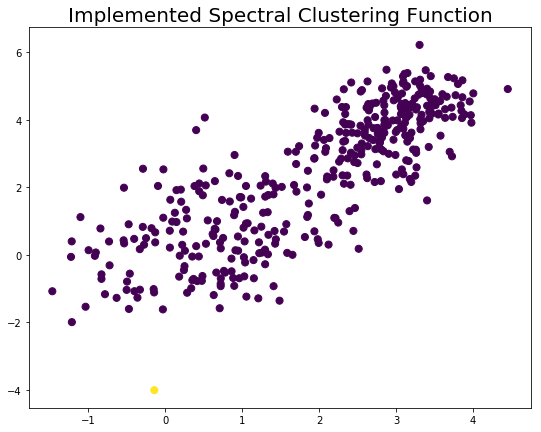

In [8]:
fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Implemented Spectral Clustering Function', size=20)
ax.scatter(data[:, 0], data[:, 1],c=spec_pred,s=dot_size, cmap=cmap)
print(data.shape)

In [9]:
#Normalized spectral clustering

def comp_laplacian(X_mat):
    D_mat = np.diag(X_mat.sum(axis = 1))
    laplacian = D_mat - X_mat
    D_alt = np.eye(X_mat.shape[0])
    for i in range(X_mat.shape[0]):
        if(D_mat[i, i] != 0):
            D_alt[i, i] /=  np.sqrt(D_mat[i, i])
    la_norm = D_alt @ laplacian @ D_alt
    return la_norm

def comp_eigs(X_mat, k):
    laplacian1 = scp.sparse.csgraph.laplacian(X_mat, normed=True)
    laplacian = comp_laplacian(X_mat)
    print(laplacian1)
    print(laplacian)
    e_vals, e_vecs = np.linalg.eig(laplacian)
    indices = np.argsort(e_vals)[-k:]
    e_vecs = e_vecs[:,indices]
    return e_vecs

def norm_spectral(data, k=2):
    #Compute the similarities matrices
    similarities = gaussian_sim(data)
    #Initialize matrices of eigenvectors
    U_mats = comp_eigs(similarities, k)
    #Row normalize 
    V_mats = U_mats/ np.mean(U_mats, axis=1).reshape((-1, 1))  
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(V_mats)
    return clusters

In [10]:
pred_labels = norm_spectral(data)

[[ 1.00000000e+00 -4.20703833e-09 -2.91912588e-03 ... -8.96886214e-06
  -2.80537444e-09 -4.05497327e-08]
 [-4.20703833e-09  1.00000000e+00 -1.19479278e-09 ... -7.87721184e-22
  -1.86955858e-02 -2.17771231e-02]
 [-2.91912588e-03 -1.19479278e-09  1.00000000e+00 ... -3.82631057e-07
  -4.60769249e-09 -8.84480843e-09]
 ...
 [-8.96886214e-06 -7.87721184e-22 -3.82631057e-07 ...  1.00000000e+00
  -3.27283673e-22 -4.40882858e-20]
 [-2.80537444e-09 -1.86955858e-02 -4.60769249e-09 ... -3.27283673e-22
   1.00000000e+00 -1.43837372e-02]
 [-4.05497327e-08 -2.17771231e-02 -8.84480843e-09 ... -4.40882858e-20
  -1.43837372e-02  1.00000000e+00]]
[[ 9.82589135e-01 -4.11788441e-09 -2.85007573e-03 ... -8.78337620e-06
  -2.74183959e-09 -3.97468010e-08]
 [-4.11788441e-09  9.75042193e-01 -1.16204218e-09 ... -7.68461982e-22
  -1.82018701e-02 -2.12637774e-02]
 [-2.85007573e-03 -1.16204218e-09  9.70141754e-01 ... -3.72336809e-07
  -4.47472462e-09 -8.61458250e-09]
 ...
 [-8.78337620e-06 -7.68461982e-22 -3.7233680

C:\Users\Alexander\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


(400, 2)


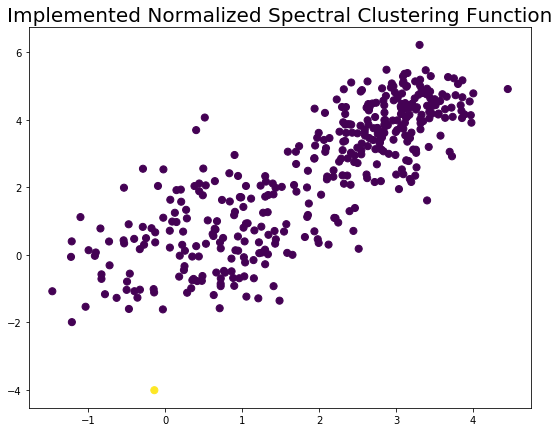

In [11]:
fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Implemented Normalized Spectral Clustering Function', size=20)
ax.scatter(data[:, 0], data[:, 1],c=spec_pred,s=dot_size, cmap=cmap)
print(data.shape)